# Implementing Sentiment Analysis

## 1. Installing packages


In [1]:
#Install/Upgrade dependencies
!pip install --upgrade pip
!pip install --upgrade scikit-learn
!pip install --upgrade sagemaker
!pip install --upgrade nltk
!pip install --upgrade seaborn

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\xps\\AppData\\Local\\Temp\\pip-uninstall-vl9f7dzc\\pip.exe'
Consider using the `--user` option or check the permissions.




  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4



     -------------------------------------- 655.0/655.0 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 132.7/132.7 kB 489.7 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 79.8/79.8 kB 317.7 kB/s eta 0:00:00
     ---------------------------------------- 10.3/10.3 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 79.6/79.6 kB 295.0 kB/s eta 0:00:00
     -------------------------------------- 110.5/110.5 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 132.9/132.9 kB 1.3 MB/s eta 0:00:00
     --------------------------------------- 52.8/52.8 kB 82.6 kB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.127.0-py2.py3-none-any.whl size=890097 sha256=4e254dbdd8755b55977d8d3b2df98d39010b42d9d47cf32d3a9478f7e

     ------------------------------------ 293.3/293.3 kB 723.9 kB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [234]:
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xps\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xps\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\xps\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xps\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The following code cell includes a few helper functions that  plot a confusion matrix and calculate other key metrics.

In [235]:

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
def print_metrics(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 



# 2. Reading the dataset

in this section, you will load the dataset. The dataset has already been downloaded by Amazon Sagemaker Studio. Use the pandas library to read the dataset.

In [236]:
df = pd.read_csv('../data/product_reviews/1429_2.csv', header=0)

# 3. Performing exploratory data analysis

In [237]:
df.head(10)

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
5,5.0,This amazon fire 8 inch tablet is the perfect ...
6,4.0,"Great for e-reading on the go, nice and light ..."
7,5.0,"I gave this as a Christmas gift to my inlaws, ..."
8,5.0,Great as a device to read books. I like that i...
9,5.0,I love ordering books and reading them with th...


In [238]:
df.shape

(34660, 2)

In [239]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  34627 non-null  float64
 1   reviews.text    34659 non-null  object 
dtypes: float64(1), object(1)
memory usage: 541.7+ KB


check null values

In [240]:
df['reviews.text'].isnull().sum()

1

In [241]:
df['reviews.rating'].isnull().sum()

33

drop null values

In [242]:
df.dropna(inplace=True)

In [243]:
df.isnull().sum()

reviews.rating    0
reviews.text      0
dtype: int64

In [244]:
df['reviews.rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [245]:
df = df.replace({1:0, 2:0,3:1,4:1,5:1})
df['reviews.rating'].value_counts()

1.0    33814
0.0      812
Name: reviews.rating, dtype: int64

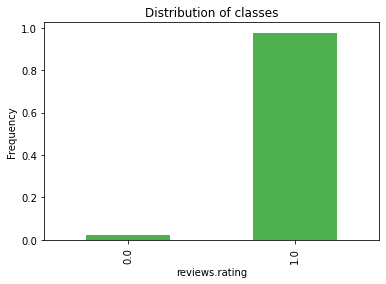

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

(df.groupby('reviews.rating').size()/len(df) ).plot(kind='bar',color = "#4CAF50")
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

# 4. Running the first pass: Minimal processing


In [247]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Challenge: Splitting the data into datasets for training, validation, and testing


In [248]:
from sklearn.model_selection import train_test_split
# uncomment the following lines and implement your solution
def split_data(df):
    # train, test_and_validate = train_test_split(....)
    # test, validate = train_test_split(....)
    ### BEGIN_SOLUTION
    train, test_and_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_and_validate,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)
    ### END_SOLUTION
    return train, validate, test

Check whether your datasets are split correctly by running the following code cell.

In [90]:
train, validate, test = split_data(df)
print(train.shape)
print(test.shape)
print(validate.shape)

(27700, 2)
(3463, 2)
(3463, 2)


# 5. Second pass: Normalizing the text
([Go to top](#Lab-4.1:-Implementing-Sentiment-Analysis))

In this section, you will perform some standard preprocessing tasks on the text before you retrain the model.

In [249]:
# Get a list of stopwords from the NLTK library
stop = stopwords.words('english')

def remove_stopwords(stopwords):
    # Implement this function
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t']
    ### BEGIN_SOLUTION
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t', 'could', 'couldn\'t',
             'did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t', 'has', 'hasn\'t', 
             'have', 'haven\'t', 'is', 'isn\'t', 'might', 'mightn\'t', 'must', 'mustn\'t',
             'need', 'needn\'t','should', 'shouldn\'t', 'was', 'wasn\'t', 'were', 
             'weren\'t', 'won\'t', 'would', 'wouldn\'t']
    ### END_SOLUTION
    return [word for word in stop if word not in excluding]

# New stopword list
stopwords = remove_stopwords(stop)


In [250]:
snow = SnowballStemmer('english')
def clean(texts):
    final_text_list=[]
    for sent in texts:
        
        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ''
            
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # Applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stopwords
            if(not w.isnumeric()) and (len(w)>2) and (w not in stopwords):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) # Final string of cleaned words
 
        final_text_list.append(final_string)
        
    return final_text_list

In [251]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[['reviews.text', ]],
                                                  df['reviews.rating'],
                                                  test_size=0.20,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

X_val, X_test, y_val, y_test = train_test_split(X_val,
                                                y_val,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)

# We will use the RandomOverSampler function to balance the classes.



In [37]:
!pip install imbalanced-learn


In [110]:
from imblearn.over_sampling import RandomOverSampler


In [111]:
ROS = RandomOverSampler(sampling_strategy=1)


In [112]:
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)


In [113]:
from collections import Counter


In [114]:
Counter(y_train_ros)


Counter({1.0: 27044, 0.0: 27044})

In [115]:
y_train_ros

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
54083    0.0
54084    0.0
54085    0.0
54086    0.0
54087    0.0
Name: reviews.rating, Length: 54088, dtype: float64

In [116]:
X_train_ros

,reviews.text
0,love alexa it is so unique I am enjoying it tr...
1,This is my 2nd purchase of this tablet! But fo...
2,Alexa is always learning and Amazon is adding ...
3,"Love it. Was debating on getting it first, but..."
4,I got it for my nephew and he very loves it.Great
...,...
54083,I was unaware that it did not Have the Google ...
54084,I have Alexa now 5 months running.You would ex...
54085,This Kindle is so overloaded with apps that I ...
54086,The sound quality of the speaker in my opinion...


dataset  distribution after handel imbalance data

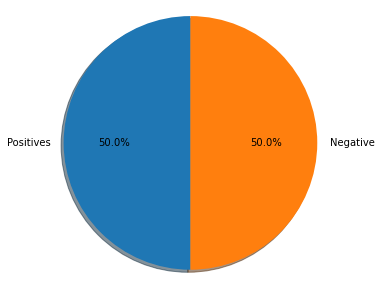

In [117]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Positives', 'Negative'

# Sizes for each slide
sizes = [y_train_ros[y_train_ros==1].shape[0], y_train_ros[y_train_ros==0].shape[0]] 

# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
# Display the chart
plt.show()


In [118]:
print('Processing the reviewText fields')
X_train_ros['reviews.text'] = clean(X_train_ros['reviews.text'])
X_val['reviews.text'] = clean(X_val['reviews.text'])
X_test['reviews.text'] = clean(X_test['reviews.text'])



Processing the reviewText fields


In [119]:
X_train_ros

,reviews.text
0,love alexa uniqu enjoy tremend
1,2nd purchas tablet posit reason bought one had...
2,alexa alway learn amazon ad new function somet...
3,love was debat get first have regret use
4,got nephew love it.great
...,...
54083,was unawar did not have googl play store formi...
54084,have alexa month running.you would expect alex...
54085,kindl overload app never use despit one best b...
54086,sound qualiti speaker opinion not worth extra ...


In [120]:
# Grab model features/inputs and target/output

text_features = [
                 'reviews.text']

model_features =  text_features
model_target = 'reviews.rating'

In [121]:
X_train_ros.shape

(54088, 1)

In [122]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################


                                
# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=100))
                                ])



# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    
    ('text_pre_0', text_processor_0, text_features[0])
    
                                    ]) 

### DATA PREPROCESSING ###
##########################

print('Datasets shapes before processing: ', X_train_ros.shape, X_val.shape, X_test.shape)

X_train_ros = data_preprocessor.fit_transform(X_train_ros)
X_val = data_preprocessor.transform(X_val)
X_test = data_preprocessor.transform(X_test)

print('Datasets shapes after processing: ', X_train_ros.shape, X_val.shape, X_test.shape)

Datasets shapes before processing:  (54088, 1) (3463, 1) (3463, 1)
Datasets shapes after processing:  (54088, 100) (3463, 100) (3463, 100)


# train model with xgboost

In [123]:
import xgboost as xgb

In [124]:
clf = xgb.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [125]:
y_train_ros.shape

(54088,)

In [126]:
clf.fit(X_train_ros,y_train_ros)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

# model evaluation

In [129]:
# fit balanced xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
model = XGBClassifier(scale_pos_weight=100)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_ros,y_train_ros, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.98869


# xgboost hyperparameter tuning

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [131]:
# execute the grid search
# execute the grid search
grid_result = grid.fit(X_train_ros,y_train_ros)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.992659 using {'scale_pos_weight': 10}
0.992610 (0.000902) with: {'scale_pos_weight': 1}
0.992659 (0.000812) with: {'scale_pos_weight': 10}
0.991724 (0.000915) with: {'scale_pos_weight': 25}
0.990292 (0.001093) with: {'scale_pos_weight': 50}
0.989442 (0.001246) with: {'scale_pos_weight': 75}
0.988588 (0.001303) with: {'scale_pos_weight': 99}
0.988690 (0.001111) with: {'scale_pos_weight': 100}
0.980111 (0.002175) with: {'scale_pos_weight': 1000}


# best model evaluation

In [132]:
from sklearn.metrics import accuracy_score
prediction = grid_result.predict(X_val)
print("Accuracy - {}".format(accuracy_score(y_pred=prediction, y_true=y_val)))

Accuracy - 0.9760323419000866


In [154]:
print_metrics(y_val, prediction) 

Sensitivity or TPR: 99.14429035113604%
Specificity or TNR: 27.027027027027028%
Precision: 98.41827768014059%
Negative Predictive Value: 40.816326530612244%
False Positive Rate: 72.97297297297297%
False Negative Rate: 0.8557096488639717%
False Discovery Rate: 1.5817223198594026%
Accuracy: 97.60323419000866%


In [133]:
from sklearn import metrics

def plot_roc(test_labels, target_predicted):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print("Sensitivity or TPR: ", Sensitivity, "%") 
    print( "Specificity or TNR: ",Specificity, "%") 
    print("Precision: ",Precision, "%") 
    print("Negative Predictive Value: ",NPV, "%") 
    print( "False Positive Rate: ",FPR,"%")
    print("False Negative Rate: ",FNR, "%") 
    print("False Discovery Rate: ",FDR, "%" )
    print("Accuracy: ",ACC, "%") 

    print("Validation AUC", metrics.roc_auc_score(y_test, prediction))

    fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    print(plt.figure())

Sensitivity or TPR:  99.14429035113604 %
Specificity or TNR:  27.027027027027028 %
Precision:  98.41827768014059 %
Negative Predictive Value:  40.816326530612244 %
False Positive Rate:  72.97297297297297 %
False Negative Rate:  0.8557096488639717 %
False Discovery Rate:  1.5817223198594026 %
Accuracy:  97.60323419000866 %
Validation AUC 0.4989990694050685
Figure(432x288)


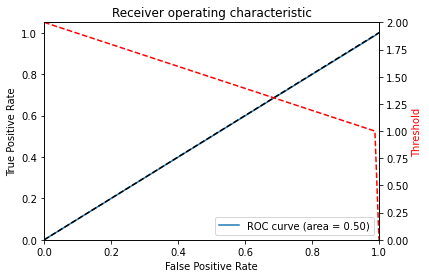

<Figure size 432x288 with 0 Axes>

In [146]:

plot_roc( y_val,prediction)

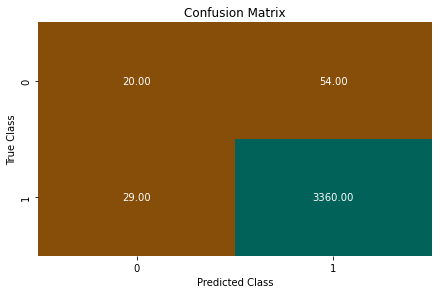

In [152]:
plot_confusion_matrix(test_labels=y_val, target_predicted=prediction) 


# save model

In [170]:
import pickle
file_name = "xgb_reg.pkl"

# save
pickle.dump(grid_result, open(file_name, "wb"))


# model in inference

In [171]:
#load model
xgb_model_loaded = pickle.load(open(file_name, "rb"))



In [172]:
twt = {'reviews.text':["I was surprised to find it did not come with any type of charging cords so I had to purchase one and then found my Sprint HTC 3D charger is faster. I would not purchase again- 1st item I've ever not liked I've purchased from Amazon"]}
twt=pd.DataFrame(twt)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = data_preprocessor.transform(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
sentiment = xgb_model_loaded.predict(twt)[0]
print(sentiment)
if(sentiment == 0):
    print("negative")
elif (sentiment == 1):
    print("positive")


0
negative


In [176]:
! pip install  wordcloud

     ------------------------------------ 153.1/153.1 kB 915.5 kB/s eta 0:00:00


# visualize the data to see more frequent words

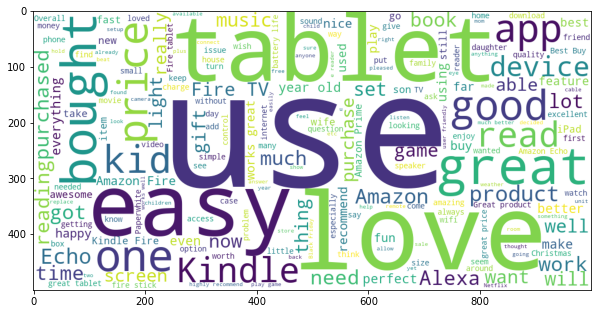

In [177]:
plt.figure(figsize=(10,6))
from wordcloud import WordCloud, STOPWORDS
word_cloud = ""
for row in df['reviews.text']:
    for word in row:
        word_cloud += " ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

# use beautifulsoup4 to make wep scraping and increase negatve class value

In [1]:
!pip install beautifulsoup4


In [2]:
!pip install lxml


In [2]:
#### Scraping reviews amazon tablet products
import os
import xml
from bs4 import BeautifulSoup
import pandas as  pd
import os
import xml
import requests
from datetime import datetime
import logging
import lxml

headers = {
    "authority": "www.amazon.com",
    "pragma": "no-cache",
    "cache-control": "no-cache",
    "dnt": "1",
    "upgrade-insecure-requests": "1",
    "user-agent": "Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36",
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",
    "sec-fetch-site": "none",
    "sec-fetch-mode": "navigate",
    "sec-fetch-dest": "document",
    "accept-language": "en-GB,en-US;q=0.9,en;q=0.8",
}
ls_out = []
for i in range(0,930):
    URLS = [f"https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={i}"]


    def get_page_html(page_url: str) -> str:
        resp = requests.get(page_url, headers=headers)
        return resp.text


    def get_reviews_from_html(page_html: str) -> BeautifulSoup:
        soup = BeautifulSoup(page_html, "lxml")
        reviews = soup.find_all("div", {"class": "a-section celwidget"})
        return reviews


    def get_review_date(soup_object: BeautifulSoup):
        date_string = soup_object.find("span", {"class": "review-date"}).get_text()
        return date_string


    def get_review_text(soup_object: BeautifulSoup) -> str:
        review_text = soup_object.find(
            "span", {"class": "a-size-base review-text review-text-content"}
        ).get_text()
        return review_text.strip()


    def get_review_header(soup_object: BeautifulSoup) -> str:
        review_header = soup_object.find(
            "a",
            {
                "class": "a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold"
            },
        ).get_text()
        return review_header.strip()


    def get_number_stars(soup_object: BeautifulSoup) -> str:
        stars = soup_object.find("span", {"class": "a-icon-alt"}).get_text()
        return stars.strip()


    def get_product_name(soup_object: BeautifulSoup) -> str:
        product = soup_object.find(
            "a", {"class": "a-size-mini a-link-normal a-color-secondary"}
        ).get_text()
        return product.strip()


    def orchestrate_data_gathering(single_review: BeautifulSoup) -> dict:
        key=get_number_stars(single_review)
        return {key: " ".join([get_review_header(single_review), get_review_text(single_review)])}


    if __name__ == '__main__':
        logging.basicConfig(level=logging.INFO)
        all_results = []

        for u in URLS:
            logging.info(u)
            try:
                html = get_page_html(u)
                reviews = get_reviews_from_html(html)
            except Exception as e:
                pass
            for rev in reviews:
                data = orchestrate_data_gathering(rev)
                all_results.append(data)
        out = pd.DataFrame.from_records(all_results)
        ls_out.append(out)
df = pd.concat(ls_out)

save_name = f"{datetime.now().strftime('%Y-%m-%d-%m')}.csv"
logging.info(f"saving to {save_name}")
df.to_csv(save_name)
logging.info('Done yayy')


INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=0
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=1
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=3
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=4
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=5
INFO:root:https://www.amazon

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=51
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=52
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=53
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=54
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=55
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=56
INFO:root:https://www.

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=102
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=103
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=104
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=105
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=106
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=107
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=152
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=153
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=154
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=155
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=156
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=157
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=202
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=203
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=204
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=205
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=206
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=207
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=252
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=253
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=254
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=255
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=256
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=257
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=302
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=303
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=304
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=305
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=306
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=307
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=352
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=353
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=354
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=355
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=356
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=357
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=402
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=403
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=404
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=405
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=406
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=407
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=452
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=453
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=454
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=455
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=456
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=457
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=502
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=503
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=504
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=505
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=506
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=507
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=552
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=553
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=554
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=555
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=556
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=557
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=602
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=603
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=604
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=605
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=606
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=607
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=652
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=653
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=654
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=655
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=656
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=657
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=702
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=703
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=704
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=705
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=706
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=707
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=752
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=753
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=754
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=755
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=756
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=757
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=802
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=803
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=804
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=805
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=806
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=807
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=852
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=853
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=854
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=855
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=856
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=857
INFO:root:https:

INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=902
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=903
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=904
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=905
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=906
INFO:root:https://www.amazon.com/Fire-HD-8-Plus-tablet/product-reviews/B0839NDRB2/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=907
INFO:root:https:

In [178]:
data1=pd.read_csv('2023-01-08-01.csv')
print(data1.shape)
data2=pd.read_csv('2023-01-08-01_4.csv')
print(data2.shape)

data3=pd.read_csv('2023-01-08-01_2.csv')
print(data2.shape)


(5010, 6)
(5000, 6)
(5000, 6)


In [225]:
scraped=pd.concat([data1,data2,data3])

In [226]:
scraped1=scraped['1.0 out of 5 stars'].dropna()

In [227]:
scraped2=scraped['2.0 out of 5 stars'].dropna()

In [228]:
scraped=scraped1.append(scraped2)

In [229]:
scraped=pd.DataFrame(scraped, columns=['reviews'])

In [231]:
scraped
scraped["rating"] = 0.0
scraped.columns

Index(['reviews', 'rating'], dtype='object')

In [232]:
scraped.info

<bound method DataFrame.info of                                                 reviews  rating
127   Why do they keep downgrading these? My old HDX...     0.0
184   Over priced Fills way outdated and app store v...     0.0
192   Runs Super Slow Ok, last time I wrote a review...     0.0
269   Don't waste your money I was in need of a new ...     0.0
324   Device Dashboard drives me crazy! If it wasn't...     0.0
...                                                 ...     ...
4891  poor use instructions this is my third tablet ...     0.0
4939  Meh Not impressed.  Should have spent the extr...     0.0
4943  Ho hum. Not very responsive. I gave up my 10 y...     0.0
4960  Trash For basic streaming of video content thi...     0.0
4979  SLOW Everything is slow with this tablet from ...     0.0

[1455 rows x 2 columns]>

In [233]:
scraped

,reviews,rating
127,Why do they keep downgrading these? My old HDX...,0.0
184,Over priced Fills way outdated and app store v...,0.0
192,"Runs Super Slow Ok, last time I wrote a review...",0.0
269,Don't waste your money I was in need of a new ...,0.0
324,Device Dashboard drives me crazy! If it wasn't...,0.0
...,...,...
4891,poor use instructions this is my third tablet ...,0.0
4939,Meh Not impressed. Should have spent the extr...,0.0
4943,Ho hum. Not very responsive. I gave up my 10 y...,0.0
4960,Trash For basic streaming of video content thi...,0.0


# start combine data and handle imblance data

In [252]:
df = pd.read_csv('../data/product_reviews/1429_2.csv', header=0)

In [253]:
df

,reviews.rating,reviews.text
0,5.0,This product so far has not disappointed. My c...
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
34655,3.0,This is not appreciably faster than any other ...
34656,1.0,Amazon should include this charger with the Ki...
34657,1.0,Love my Kindle Fire but I am really disappoint...
34658,1.0,I was surprised to find it did not come with a...


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.rating  34627 non-null  float64
 1   reviews.text    34659 non-null  object 
dtypes: float64(1), object(1)
memory usage: 541.7+ KB


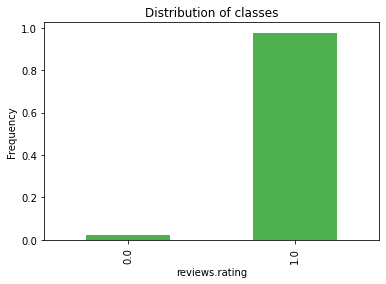

In [255]:
df['reviews.text'].isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()
df['reviews.rating'].value_counts()
df = df.replace({1:0, 2:0,3:1,4:1,5:1})
df['reviews.rating'].value_counts()
import matplotlib.pyplot as plt
import seaborn as sns

(df.groupby('reviews.rating').size()/len(df) ).plot(kind='bar',color = "#4CAF50")
plt.ylabel('Frequency')
plt.title('Distribution of classes')
plt.show()

In [288]:
df

,reviews.rating,reviews.text
0,1.0,This product so far has not disappointed. My c...
1,1.0,great for beginner or experienced person. Boug...
2,1.0,Inexpensive tablet for him to use and learn on...
3,1.0,I've had my Fire HD 8 two weeks now and I love...
4,1.0,I bought this for my grand daughter when she c...
...,...,...
34655,1.0,This is not appreciably faster than any other ...
34656,0.0,Amazon should include this charger with the Ki...
34657,0.0,Love my Kindle Fire but I am really disappoint...
34658,0.0,I was surprised to find it did not come with a...


In [289]:
data=df['reviews.text']
data.append(scraped['reviews'])

0       This product so far has not disappointed. My c...
1       great for beginner or experienced person. Boug...
2       Inexpensive tablet for him to use and learn on...
3       I've had my Fire HD 8 two weeks now and I love...
4       I bought this for my grand daughter when she c...
                              ...                        
4891    poor use instructions this is my third tablet ...
4939    Meh Not impressed.  Should have spent the extr...
4943    Ho hum. Not very responsive. I gave up my 10 y...
4960    Trash For basic streaming of video content thi...
4979    SLOW Everything is slow with this tablet from ...
Length: 36081, dtype: object

In [290]:
rata=df['reviews.rating']
rata.append(scraped['rating'])

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4891    0.0
4939    0.0
4943    0.0
4960    0.0
4979    0.0
Length: 36081, dtype: float64

In [291]:
rata

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
34655    1.0
34656    0.0
34657    0.0
34658    0.0
34659    0.0
Name: reviews.rating, Length: 34626, dtype: float64

In [292]:
rating=pd.DataFrame(rata)

In [296]:
data=pd.DataFrame(data)

In [294]:
rating

,reviews.rating
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
34655,1.0
34656,0.0
34657,0.0
34658,0.0


In [299]:
data

,reviews.text
0,This product so far has not disappointed. My c...
1,great for beginner or experienced person. Boug...
2,Inexpensive tablet for him to use and learn on...
3,I've had my Fire HD 8 two weeks now and I love...
4,I bought this for my grand daughter when she c...
...,...
34655,This is not appreciably faster than any other ...
34656,Amazon should include this charger with the Ki...
34657,Love my Kindle Fire but I am really disappoint...
34658,I was surprised to find it did not come with a...


In [329]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data[['reviews.text', ]],
                                                 rating['reviews.rating'],
                                                  test_size=0.30,
                                                  shuffle=True,
                                                  random_state=324
                                                 )



In [330]:
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)
from collections import Counter
Counter(y_train_ros)





Counter({0.0: 23658, 1.0: 23658})

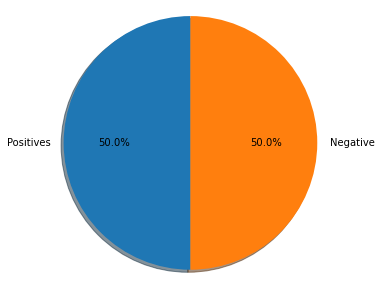

In [331]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))

# labels for the two classes
labels = 'Positives', 'Negative'

# Sizes for each slide
sizes = [y_train_ros[y_train_ros==1].shape[0], y_train_ros[y_train_ros==0].shape[0]] 

# Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
# Display the chart
plt.show()


In [332]:
print('Processing the reviewText fields')
X_train_ros['reviews.text'] = clean(X_train_ros['reviews.text'])
X_val['reviews.text'] = clean(X_val['reviews.text'])



Processing the reviewText fields


In [333]:
def remove_emoji(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis,'',text)
    return text

In [334]:
print("start remove emojis from data")
X_train_ros['reviews.text'] = X_train_ros['reviews.text'].apply(lambda x : remove_emoji(x))
X_val['reviews.text'] = X_val['reviews.text'].apply(lambda x : remove_emoji(x))

print("finish.........")

start remove emojis from data
finish.........


In [335]:
# Grab model features/inputs and target/output

text_features = [
                 'reviews.text']

model_features =  text_features
model_target = 'reviews.rating'

In [336]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### COLUMN_TRANSFORMER ###
##########################


                                
# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=200))
                                ])



# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    
    ('text_pre_0', text_processor_0, text_features[0])
    
                                    ]) 

### DATA PREPROCESSING ###
##########################

print('Datasets shapes before processing: ', X_train_ros.shape, X_val.shape)

X_train_ros = data_preprocessor.fit_transform(X_train_ros)
X_val = data_preprocessor.transform(X_val)

print('Datasets shapes after processing: ', X_train_ros.shape, X_val.shape)

Datasets shapes before processing:  (47316, 1) (10388, 1)
Datasets shapes after processing:  (47316, 200) (10388, 200)


In [337]:
import xgboost as xgb
clf = xgb.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
clf.fit(X_train_ros,y_train_ros)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [338]:
# fit balanced xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
model = XGBClassifier(scale_pos_weight=100)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_ros,y_train_ros, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.99369


In [339]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [340]:
# execute the grid search
# execute the grid search
grid_result = grid.fit(X_train_ros,y_train_ros)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996134 using {'scale_pos_weight': 10}
0.995985 (0.000683) with: {'scale_pos_weight': 1}
0.996134 (0.000634) with: {'scale_pos_weight': 10}
0.995536 (0.000835) with: {'scale_pos_weight': 25}
0.994707 (0.000925) with: {'scale_pos_weight': 50}
0.994103 (0.000835) with: {'scale_pos_weight': 75}
0.993564 (0.001075) with: {'scale_pos_weight': 99}
0.993694 (0.000926) with: {'scale_pos_weight': 100}
0.987466 (0.001897) with: {'scale_pos_weight': 1000}


In [341]:
from sklearn.metrics import accuracy_score
prediction = grid_result.predict(X_val)
print("Accuracy - {}".format(accuracy_score(y_pred=prediction, y_true=y_val)))

Accuracy - 0.975452445128995


In [342]:
print_metrics(y_val, prediction) 

Sensitivity or TPR: 99.3304450571091%
Specificity or TNR: 19.396551724137932%
Precision: 98.18004866180048%
Negative Predictive Value: 39.823008849557525%
False Positive Rate: 80.60344827586206%
False Negative Rate: 0.669554942890902%
False Discovery Rate: 1.8199513381995134%
Accuracy: 97.5452445128995%


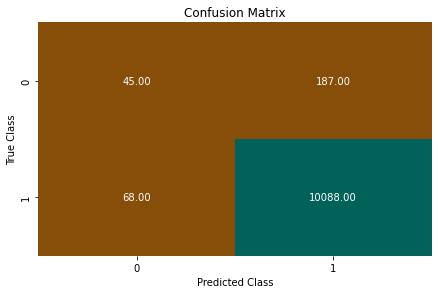

In [343]:
plot_confusion_matrix(test_labels=y_val, target_predicted=prediction) 


In [344]:
import pickle
file_name = "xgb_best.pkl"

# save
pickle.dump(grid_result, open(file_name, "wb"))




In [345]:
#load model
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [346]:
twt = {'reviews.text':["I was surprised to find it did not come with any type of charging cords so I had to purchase one and then found my Sprint HTC 3D charger is faster. I would not purchase again- 1st item I've ever not liked I've purchased from Amazon"]}
twt=pd.DataFrame(twt)
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = data_preprocessor.transform(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
sentiment = xgb_model_loaded.predict(twt)[0]
print(sentiment)
if(sentiment == 0):
    print("negative")
elif (sentiment == 1):
    print("positive")


0
negative
